<a href="https://colab.research.google.com/github/luishpinto/wind-turbine/blob/master/pkurtosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import github
except:
  !pip install PyGithub
  import github

In [2]:
import os.path

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.size'] = 12

from scipy.io import loadmat
from scipy.signal import stft
from scipy.stats import kurtosis

from mpl_toolkits.mplot3d import Axes3D

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [5]:
%tensorflow_version 1.x
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *

TensorFlow 1.x selected.


In [6]:
g = github.Github('user','password')
repo = g.get_user().get_repo('wind-turbine')
files = np.array([],dtype = str)
for i in repo.get_contents('/data'):
  files = np.append(files,i.name)

for i in files:
  if not os.path.exists(i):
    !wget -O {i} 'https://github.com/luishpinto/wind-turbine/blob/master/data/{i}?raw=true'

In [7]:
def mavg(y,w = 5):
  avg = []
  for i in range(len(y)):
    if (i == 0):
      avg.append(y[0])
    else:
      lw = max((i - w),0)
      avg.append(np.mean(y[lw:(i + 1)]))

  return np.asarray(avg)

In [8]:
def plotConfusionMatrix(dtrue,dpred,classes,\
                        cmap = plt.cm.Blues,bsize = 1.0):
  
  cm = confusion_matrix(dtrue,dpred,normalize = 'true')
  
  fig,ax = plt.subplots(figsize = (np.shape(classes)[0] * 1.25 * bsize,\
                                   np.shape(classes)[0] * 1.25 * bsize))
  im = ax.imshow(cm,interpolation = 'nearest',cmap = cmap)
  
  ax.set(xticks = np.arange(cm.shape[1]),
         yticks = np.arange(cm.shape[0]),
         xticklabels = classes,
         yticklabels = classes,
         ylabel = 'True Efficiency',
         xlabel = 'Predicted Efficiency')
  
  plt.setp(ax.get_xticklabels(),rotation = 90,ha = 'right',
           rotation_mode = 'anchor')

  fmt = '.2f'

  thresh = cm.max() / 2.0
  
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j,i,format(cm[i,j],fmt),ha = 'center',va = 'center',
              color = 'white' if cm[i,j] > thresh else 'black')
      
  fig.tight_layout()
  
  return ax

In [9]:
s = []
for i in files:
  s.append(loadmat(i)['vibration'].flatten())

s = np.asarray(s)

In [10]:
fs = int(s.shape[1] / 6.0)
t = np.linspace(0.0,6.0,s.shape[1])

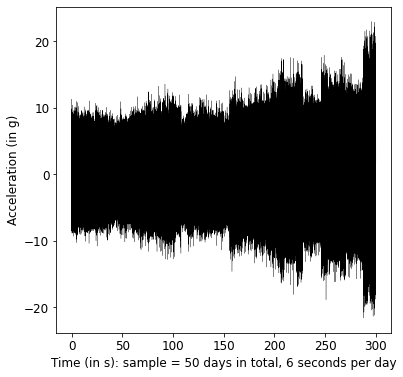

In [11]:
plt.subplots(figsize = (6.0,6.0))
for i in range(s.shape[0]):
  plt.plot(t + i * 6.0,s[i],color = 'black',lw = 0.25)

plt.xlabel('Time (in s): sample = 50 days in total, 6 seconds per day')
plt.ylabel('Acceleration (in g)')
plt.show()

In [12]:
f = []
fft = []

wnd = 128

for i in range(s.shape[0]):
  u,v,w = stft(s[i],fs,nperseg = wnd,noverlap = int(0.8 * wnd),nfft = int(2.0 * wnd))
  f.append(u)
  fft.append(kurtosis(np.abs(w),fisher = False,axis = 1))

f = np.asarray(f)
fft = np.asarray(fft)

fftn = (fft - fft.min()) / (fft.max() - fft.min())
for i in range(fftn.shape[0]):
  fftn[i] = mavg(fftn[i],w = 13)

fftn = np.asarray(fftn)
n = np.ones_like(f[0])

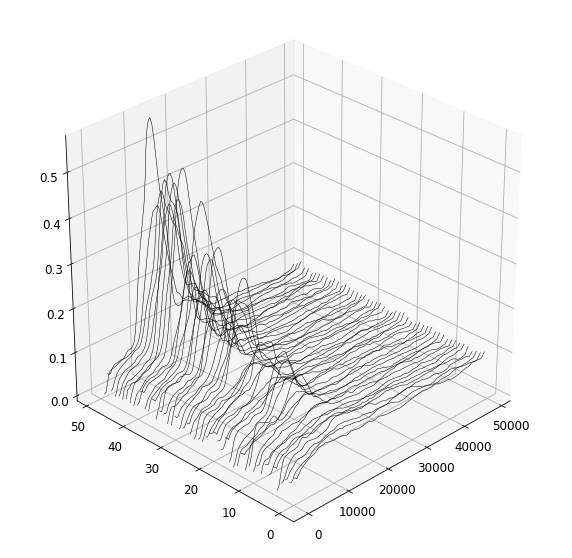

In [13]:
fig = plt.figure(figsize = (10.0,10.0))
ax = plt.axes(projection = '3d')
ax.view_init(30,225)
for i in range(f.shape[0]):
  ax.plot(f[i],i * n,fftn[i],color = 'black',linewidth = 0.50)

plt.show()

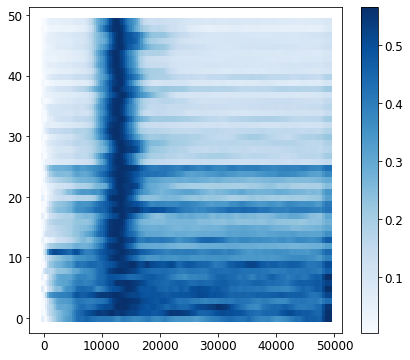

In [14]:
plt.subplots(figsize = (7.0,6.0))
for i in range(f.shape[0]):
  plt.scatter(f[i],n * i,c = fftn[i],marker = 's',cmap = plt.cm.Blues)

plt.colorbar()
plt.show()

In [15]:
X = fftn
X = X.reshape(-1,f.shape[1],1)
y = np.zeros(X.shape[0],dtype = int)
y[-25:] = 1

label = to_categorical(y)

In [16]:
mdl = Sequential()

mdl.add(Conv1D(100,8,activation = 'relu',\
               input_shape = (f.shape[1],1)))
mdl.add(Conv1D(100,8,activation = 'relu'))
mdl.add(MaxPooling1D(3))
mdl.add(Conv1D(160,8,activation = 'relu'))
mdl.add(GlobalAveragePooling1D())
mdl.add(Dropout(0.5))
mdl.add(Dense(2,activation = 'softmax'))

print(mdl.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 122, 100)          900       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 115, 100)          80100     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 38, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 31, 160)           128160    
_________________________________________________________________
global_average_pooling1d (Gl (None, 160)               0         
_________________________________________________________________
dropout (Dropout)            (None, 160)               0         
_________________________________________

In [17]:
mdl.compile(loss = 'categorical_crossentropy',\
            optimizer = 'adam',metrics = ['accuracy'])

In [18]:
batch,epoch = 32,15

Xtrain,Xtest,ytrain,ytest = train_test_split(X,label,\
                                             random_state = 21,\
                                             test_size = 0.50)

hist = mdl.fit(Xtrain,ytrain,batch_size = batch,\
               epochs = epoch,validation_split = 0.2,verbose = 0)

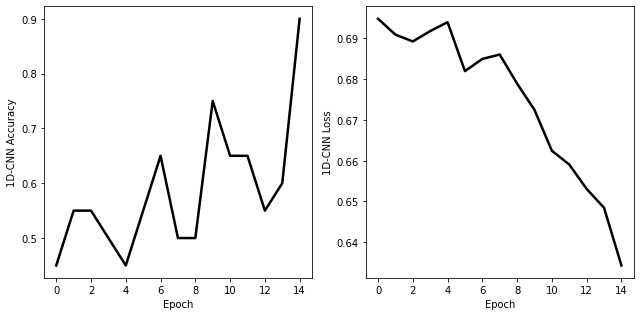

In [19]:
matplotlib.rcParams['font.size'] = 10

plt.subplots(1,2,figsize = (9.0,4.5),sharex = True)
plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['acc'],\
         color = 'black',lw = 2.50)
plt.ylabel('1D-CNN Accuracy')
plt.xlabel('Epoch')
plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['loss'],\
         color = 'black',lw = 2.50)
plt.ylabel('1D-CNN Loss')
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig('fig-3.ps',dpi = 300,format = 'ps')
plt.show()

In [20]:
print(mdl.evaluate(Xtest,ytest,verbose = 2))

25/25 - 0s - loss: 0.6015 - acc: 0.8000
[0.6015313267707825, 0.8]


In [21]:
print(classification_report(np.where(ytest != 0)[1],\
                            mdl.predict_classes(Xtest)))

              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.76      0.93      0.84        14

    accuracy                           0.80        25
   macro avg       0.82      0.78      0.79        25
weighted avg       0.81      0.80      0.79        25



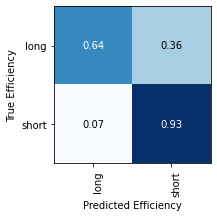

In [22]:
matplotlib.rcParams['font.size'] = 10

plotConfusionMatrix(np.argmax(ytest,axis = 1),\
                    np.argmax(mdl.predict(Xtest),axis = 1),\
                    ['long','short'],\
                    bsize = 1.25)
plt.show()